In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor/2/1231.png
/kaggle/input/brain-tumor/2/641.png
/kaggle/input/brain-tumor/2/1088.png
/kaggle/input/brain-tumor/2/173.png
/kaggle/input/brain-tumor/2/1958.png
/kaggle/input/brain-tumor/2/815.png
/kaggle/input/brain-tumor/2/491.png
/kaggle/input/brain-tumor/2/1924.png
/kaggle/input/brain-tumor/2/1084.png
/kaggle/input/brain-tumor/2/718.png
/kaggle/input/brain-tumor/2/709.png
/kaggle/input/brain-tumor/2/889.png
/kaggle/input/brain-tumor/2/379.png
/kaggle/input/brain-tumor/2/780.png
/kaggle/input/brain-tumor/2/248.png
/kaggle/input/brain-tumor/2/94.png
/kaggle/input/brain-tumor/2/480.png
/kaggle/input/brain-tumor/2/1145.png
/kaggle/input/brain-tumor/2/1944.png
/kaggle/input/brain-tumor/2/236.png
/kaggle/input/brain-tumor/2/1343.png
/kaggle/input/brain-tumor/2/771.png
/kaggle/input/brain-tumor/2/675.png
/kaggle/input/brain-tumor/2/340.png
/kaggle/input/brain-tumor/2/48.png
/kaggle/input/brain-tumor/2/1948.png
/kaggle/input/brain-tumor/2/1878.png
/kaggle/input/brain-

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import shutil
from tensorflow.keras import regularizers

from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.models import load_model

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Dropout, MaxPool2D , Activation, Flatten, Dense, AvgPool2D, Lambda, BatchNormalization, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [4]:
!pip install visualkeras
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.8/989.8 kB 8.5 MB/s eta 0:00:0000:0100:01


In [5]:
import visualkeras

In [6]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch

In [7]:
data_dir = '../input/brain-tumor' 
class_names = os.listdir(data_dir)
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
               for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]

In [8]:
N=['1','2','3']
Name=[ 'meningioma','glioma','pituitary tumor' ]
normal_mapping=dict(zip(Name,N))
reverse_mapping=dict(zip(N,Name))

In [9]:
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

In [10]:
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 3064
Image dimensions: 512 x 512
Label names: ['2', '3', '1']
Label counts: [1426, 930, 708]


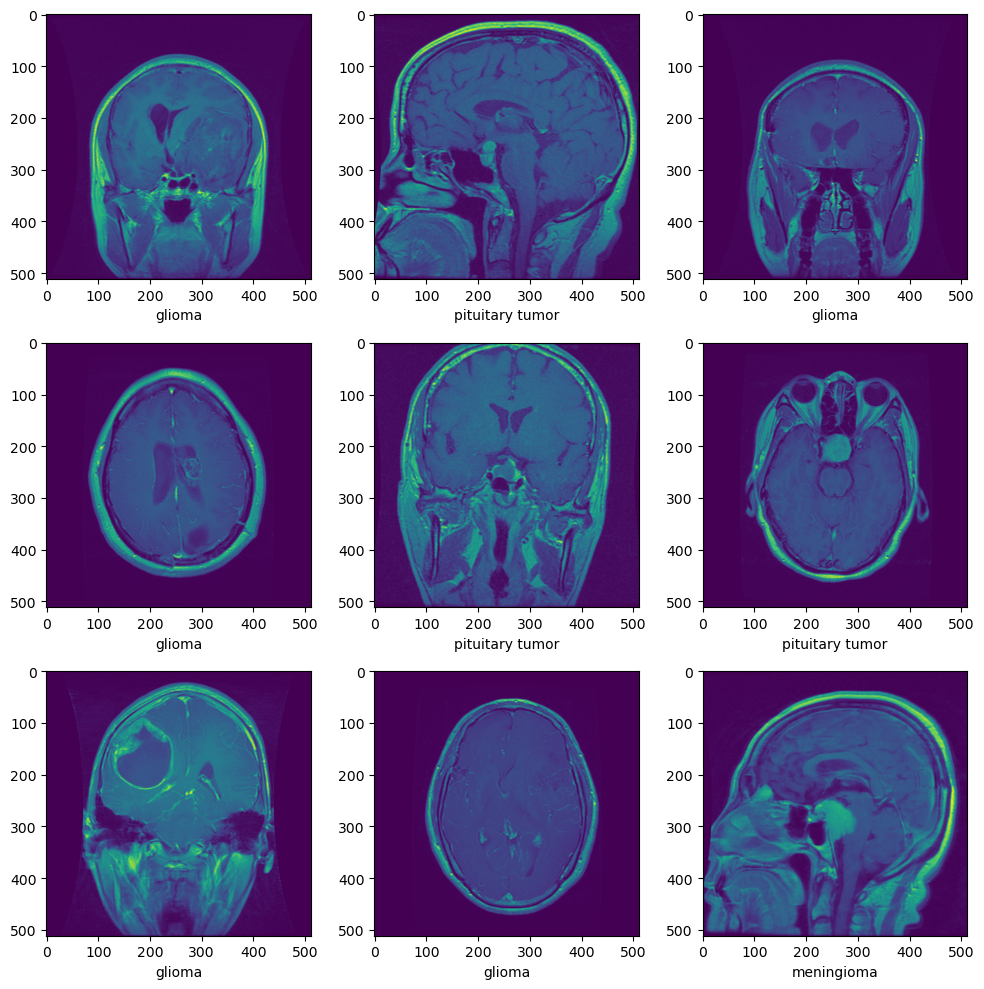

In [11]:
plt.subplots(3,3, figsize=(10,10))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3,3, i+1)
    plt.xlabel(reverse_mapping[class_names[image_label_list[k]]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [12]:
len(image_file_list)

3064

In [13]:
len(image_label_list)

3064

In [14]:
set(image_label_list)

{0, 1, 2}

In [15]:
data_df = pd.DataFrame({'image_file_path': image_file_list, 'label': image_label_list})

In [16]:
data_df.head(5)

,image_file_path,label
0,../input/brain-tumor/2/1231.png,0
1,../input/brain-tumor/2/641.png,0
2,../input/brain-tumor/2/1088.png,0
3,../input/brain-tumor/2/173.png,0
4,../input/brain-tumor/2/1958.png,0


In [17]:
data_df.isna().sum()

image_file_path    0
label              0
dtype: int64

<AxesSubplot:>

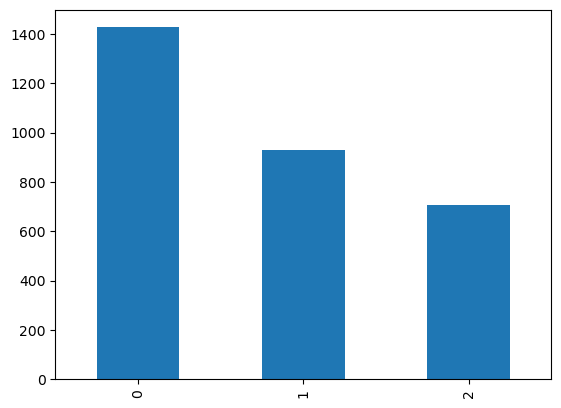

In [18]:
data_df["label"].value_counts().plot.bar()

In [19]:
#All the images are having same dimensions
for img_path in data_df["image_file_path"][:10]:
    print(Image.open(img_path).size)

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)


**Common parameters for all the models**

In [20]:
evaluation_metrics = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, 0]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap_resized = resize(heatmap,(320, 256))
    return heatmap_resized

In [23]:
N=[0,1,2]
reverse_mapping=dict(zip(N,Name))
reverse_mapping

{0: 'meningioma', 1: 'glioma', 2: 'pituitary tumor'}

In [24]:
data_df['label'] = data_df['label'].map(reverse_mapping).fillna(data_df['label'])

In [25]:
data_df.head(2)

,image_file_path,label
0,../input/brain-tumor/2/1231.png,meningioma
1,../input/brain-tumor/2/641.png,meningioma


**Train test split**

In [26]:
train_val_dataset, test_dataset = train_test_split(data_df, test_size=0.2, shuffle=True, random_state=42)

**Train Validation Set split**

In [27]:
train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.15, shuffle=True, random_state=42)

**Please refer to this notebook from this cell. The above part is implemented in the other notebook, which is in the same GitHub Repo folder.**

**Transfer Learning Xception model**

Define two ImageDataGenerator objects train_generator and test_generator for data augmentation and preprocessing of images. The train_generator applies several image transformations such as zoom, brightness adjustment, and shifting, and normalizes the data. The test_generator only applies data normalization.

In [51]:
#Now let's do data augmentation
train_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input,
                                   zoom_range=[0.75, 1],
                                   brightness_range=(0.8, 1.2),
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True)
test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

Define two image generators (train_img_gen and val_img_gen) using the flow_from_dataframe method of a Keras ImageDataGenerator object. The generators will load and preprocess the images from the specified dataframes (train_dataset and val_dataset) and create batches of 64 images each with their corresponding labels in one-hot encoded format. The images will be resized to 256x256 pixels.

In [52]:
train_img_gen = train_generator.flow_from_dataframe(
    dataframe=train_dataset,
    x_col='image_file_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 2083 validated image filenames belonging to 3 classes.


In [53]:
val_img_gen = train_generator.flow_from_dataframe(
    dataframe=val_dataset,
    #directory=train_set_folder_path,
    x_col='image_file_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 368 validated image filenames belonging to 3 classes.


Define a data generator for testing data. It takes in a pandas dataframe containing the image file paths and their corresponding labels, and generates batches of 64 preprocessed images of size 256x256 along with their labels. The generated data is not shuffled.

In [54]:
test_img_gen = test_generator.flow_from_dataframe(
                              dataframe=test_dataset,
                              x_col='image_file_path',
                              y_col='label',
                              target_size=(256, 256),
                              batch_size=64,
                              seed=2022,
                              shuffle=False)

Found 613 validated image filenames belonging to 3 classes.


**Xception model Pre-processed image visualization**

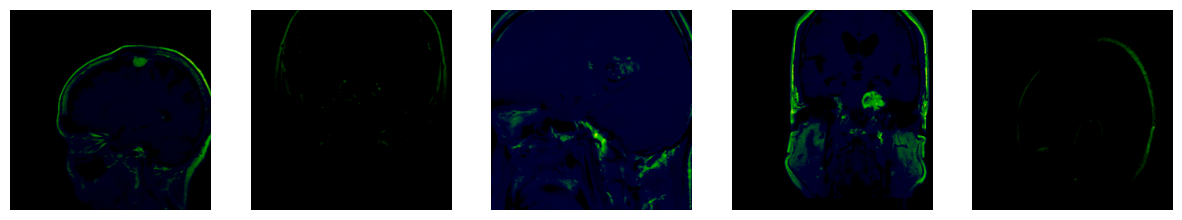

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(train_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

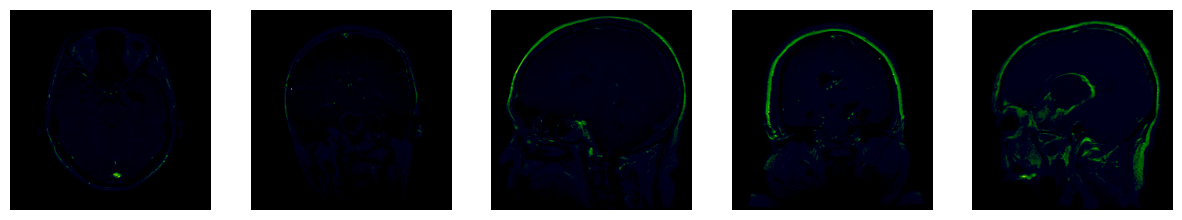

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(test_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

**Let's take the already pre-trained Xception model and apply the transfer learning on our problem set**

In [57]:
#From professor's notebook, need to implement below callback part

model_path = "/kaggle/working/best_xception_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

monitor = tf.keras.callbacks.ModelCheckpoint(model_path,
                                             monitor='val_loss',
                                             verbose=1,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def schedule(epoch, lr):
    if epoch%3 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(schedule,verbose = 1)

model_callbacks = [
    early_stop, 
    lr_schedule,
    monitor]

Define a custom neural network architecture by utilizing the pre-trained Xception model as the base layer. The last layer of the Xception model is extracted and used as an input for the custom layers. The custom layers include global average pooling, dropout, and fully connected layers with different numbers of neurons and activation functions. Finally, the output layer has 3 neurons with a softmax activation function for multi-class classification.

In [58]:
# inputs = tf.keras.layers.Input((312,312,3))
# Xception_model=tf.keras.applications.xception.Xception(include_top=False, weights="imagenet",input_shape=(312,312,3), pooling='avg')
# last_layer = Xception_model.get_layer('block14_sepconv2_act')
# last_output = last_layer.output
# input_l = Xception_model.input
# base_model1 = tf.keras.Model(input_l, last_output)

# x = base_model1(inputs)
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.25)(x)
# x = Dense(2048, activation = "relu")(x)
# x = Dropout(0.25)(x)
# x = Dense(512, activation = "relu")(x)
# x = Dropout(0.25)(x)
# x = Dense(64, activation = "relu")(x)
# x = Dropout(0.25)(x)
# outputs = Dense(3, activation = "softmax")(x)

# Xception_transfer_learning_model = tf.keras.Model(inputs, outputs)

Define a convolutional neural network (CNN) model for multi-class classification. The base_model is a pre-trained Xception model from the ImageNet dataset, and it is followed by a BatchNormalization layer, a Dense layer with L1 and L2 regularization, a Dropout layer, and finally, an output Dense layer with softmax activation function for three classes.

In [59]:
base_model = tf.keras.applications.xception.Xception(include_top=False, weights="imagenet",input_shape=(256, 256, 3), pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(3, activation= 'softmax')
])




83683744/83683744 [==============================] - 2s 0us/step


Compile the model by specifying the optimizer, loss function, and evaluation metric to be used during training. In this case, the Adam optimizer is used with a learning rate of 0.0005, categorical cross-entropy is used as the loss function, and accuracy is used as the evaluation metric.

In [60]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0005), loss= 'categorical_crossentropy', metrics= ['accuracy'])
# Xception_transfer_learning_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=evaluation_metrics)

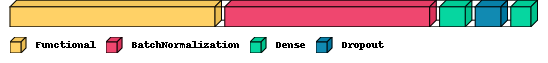

In [62]:
from PIL import ImageFont
# font = ImageFont.truetype("../input/arialfont/arial.ttf", 12)
visualkeras.layered_view(model, to_file='model_architecture_xception.png', legend=True
#                          , font=font
                        )

**Model Training**

In [64]:
Actual_epochs = 30

for i in range(Actual_epochs):
    model_progress = model.fit(
        train_img_gen,
        batch_size=10240,
        steps_per_epoch = 64,
        validation_data = val_img_gen,
        #epochs = 60,
        epochs = 1,
        callbacks=model_callbacks
    )

    model.save(model_path)





Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.



33/64 [==============>...............] - ETA: 1:07 - loss: 8.0136 - accuracy: 0.7849



Epoch 1: val_loss improved from inf to 7.55744, saving model to /kaggle/working/best_xception_cnn.h5



64/64 [==============================] - 120s 1s/step - loss: 8.0136 - accuracy: 0.7849 - val_loss: 7.5574 - val_accuracy: 0.6304 - lr: 5.0000e-04







Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.



33/64 [==============>...............] - ETA: 1:06 - loss: 5.8850 - accuracy: 0.9347



Epoch 1: val_loss improved from 7.55744 to 6.03556, saving model to /kaggle/working/best_xception_cnn.h5



64/64 [==============================] - 85s 1s/step - loss: 5.8850 - accuracy: 0.9347 - val_loss: 6.0356 - val_accuracy: 0.7255 - lr: 5.0000e-04







Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.



33/64 [==============>...............] - ETA: 1:07 - lo

Predict the class labels for the test images using the trained model, then it converts the class indices to class labels using a dictionary that maps the class indices to their respective labels.

In [67]:
test_pred= model.predict(test_img_gen)
predicted_class=np.argmax(test_pred,axis=1)
class_labels = (test_img_gen.class_indices)
prediction = [dict((v,i) for i,v in class_labels.items())[i] for i in predicted_class]
print("Predicted :", predicted_class[:5])
actual_label = test_img_gen.classes
print("actual_label: ", actual_label[:5])

10/10 [==============================] - 14s 1s/step



Predicted : [1 1 1 0 0]



actual_label:  [1, 1, 1, 0, 0]


**Accuracy**

In [68]:
accuracy = accuracy_score(predicted_class,actual_label)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.41%


**Plot consfusion metrics**

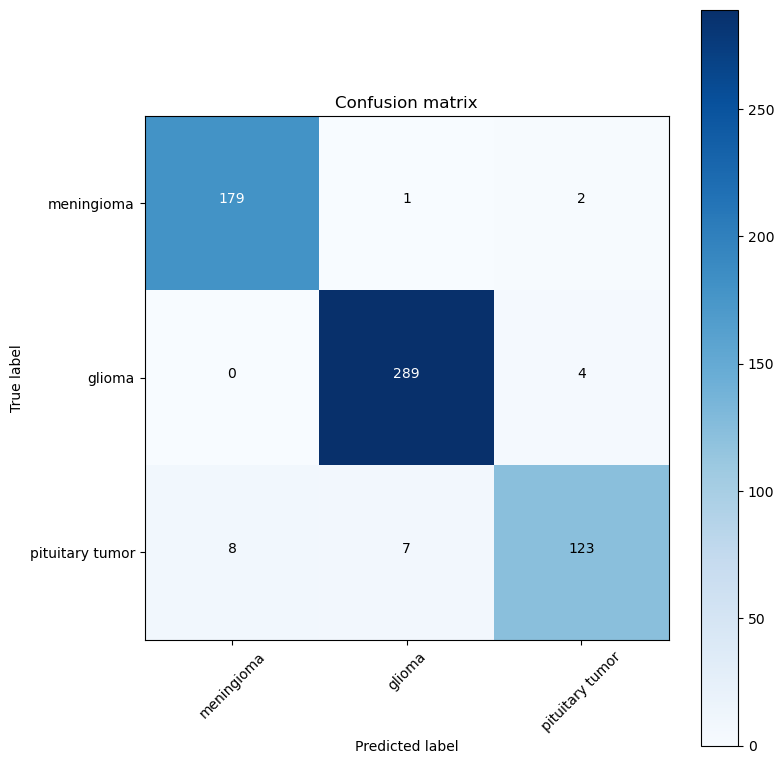

In [69]:
cnf_matrix = confusion_matrix(actual_label, predicted_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=[ 'meningioma','glioma','pituitary tumor'],
                      title='Confusion matrix')
plt.show()

**All the steps from the above Xception model are implemented below but with respect to MobileNet model**

**Transfer Learning MobileNet model**

In [29]:
#Now let's do data augmentation
train_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
                                   zoom_range=[0.75, 1],
                                   brightness_range=(0.8, 1.2),
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True)

test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

In [30]:
train_img_gen = train_generator.flow_from_dataframe(
    dataframe=train_dataset,
    x_col='image_file_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 2083 validated image filenames belonging to 3 classes.


In [31]:
val_img_gen = train_generator.flow_from_dataframe(
    dataframe=val_dataset,
    x_col='image_file_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=64,
    seed=2022,
    shuffle=True,
    class_mode='categorical'
)

Found 368 validated image filenames belonging to 3 classes.


In [32]:
test_img_gen = test_generator.flow_from_dataframe(
                              dataframe=test_dataset,
                              x_col='image_file_path',
                              y_col='label',
                              target_size=(256, 256),
                              batch_size=64,
                              seed=2022,
                              shuffle=False)

Found 613 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


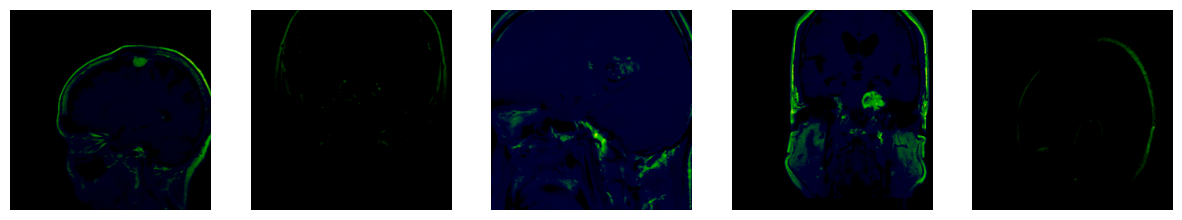

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(train_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

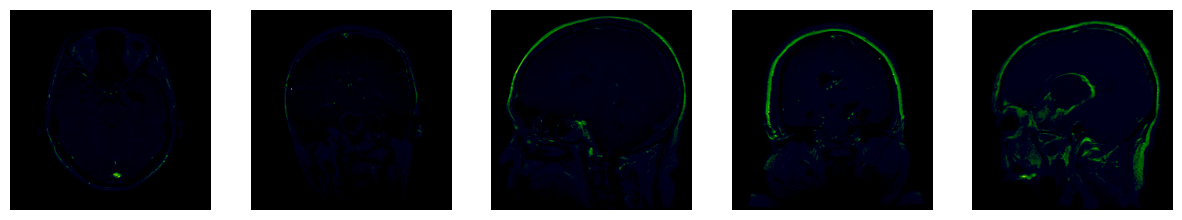

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
for i in range(5):
	image = next(test_img_gen)[0][0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

In [35]:
#From professor's notebook, need to implement below callback part

model_path = "/kaggle/working/best_mobilenetv2_tumor_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

monitor = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss',\
                                             verbose=1,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def schedule(epoch, lr):
    if epoch%3 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(schedule,verbose = 1)

model_callbacks = [early_stop, lr_schedule, monitor]

In [36]:
# inputs = tf.keras.layers.Input((256,256,3))
# MobileNet_model=tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', pooling='max', input_shape=(256, 256, 3))

# x = MobileNet_model(inputs)
# x = Dropout(0.25)(x)
# x = Dense(2048, activation = "relu")(x)
# x = Dropout(0.25)(x)
# x = Dense(512, activation = "relu")(x)
# x = Dropout(0.25)(x)
# x = Dense(64, activation = "relu")(x)
# x = Dropout(0.25)(x)
# outputs = Dense(3, activation = "softmax")(x)

# MobileNet_transfer_learning_model = tf.keras.Model(inputs, outputs)

In [37]:
MobileNet_transfer_learning_model = load_model("/kaggle/input/mobilenetmodel/best_mobilenetv2_tumor_cnn.h5")

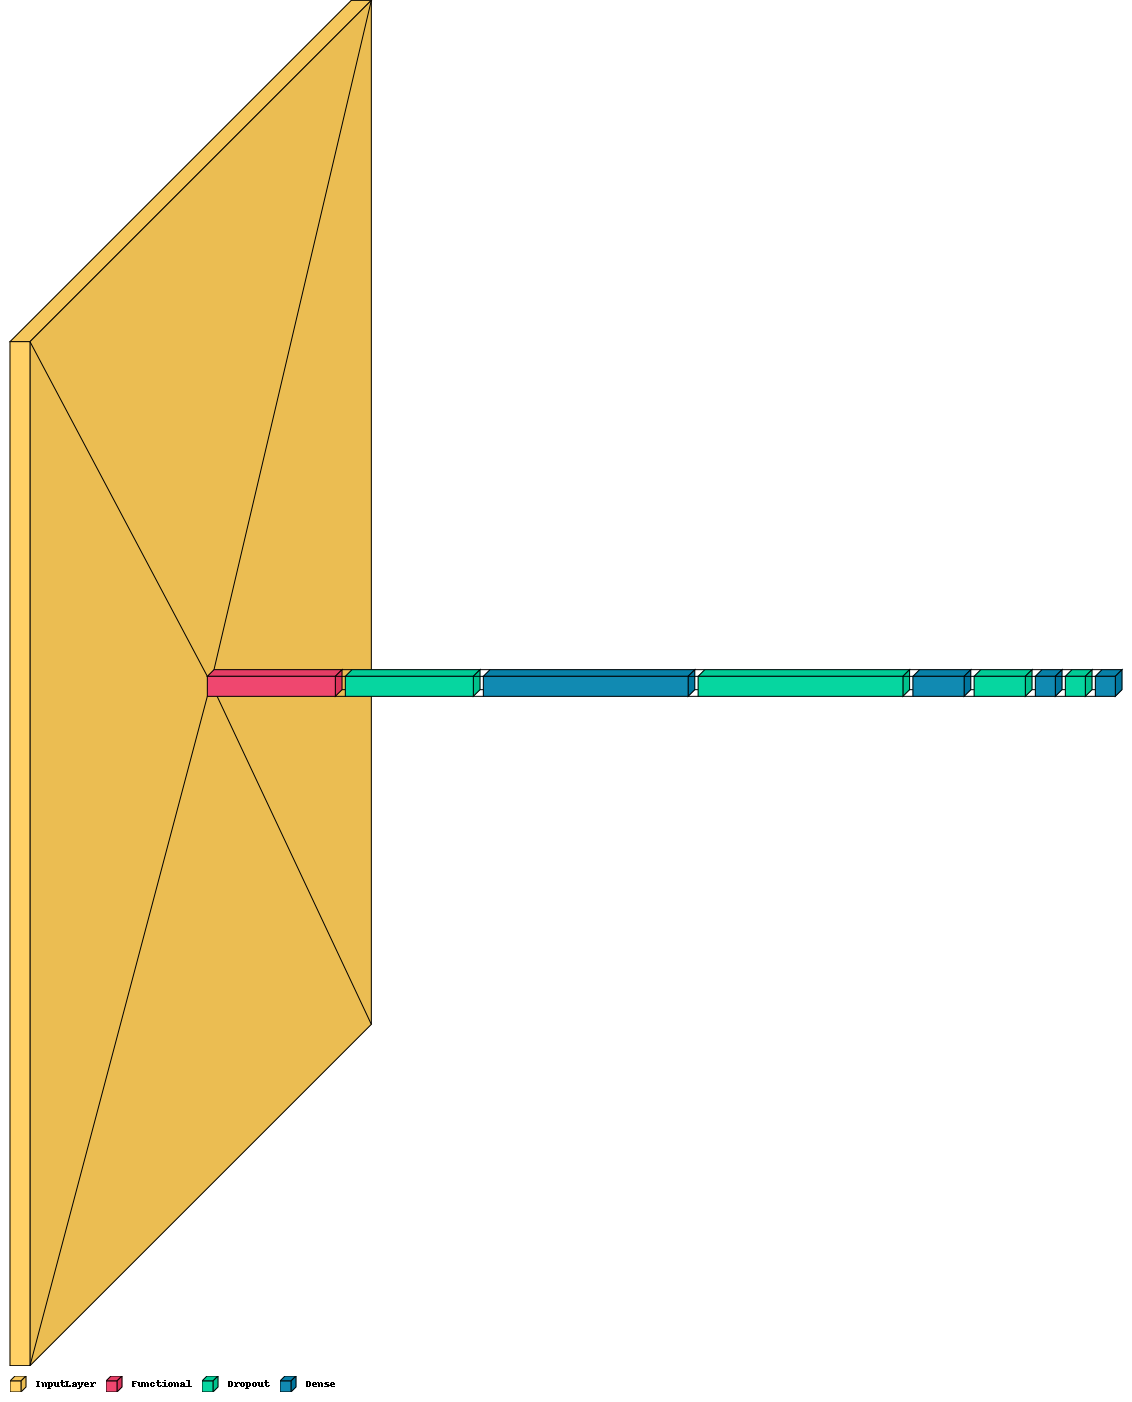

In [38]:
from PIL import ImageFont
# font = ImageFont.truetype("../input/arialfont/arial.ttf", 12)
visualkeras.layered_view(MobileNet_transfer_learning_model, to_file='model_architecture_xception.png', legend=True
#                          , font=font
                        )

In [39]:
MobileNet_transfer_learning_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0005), loss= 'categorical_crossentropy', metrics= evaluation_metrics)

In [55]:
Actual_epochs = 1

for i in range(Actual_epochs):
    model_progress = MobileNet_transfer_learning_model.fit(
        train_img_gen,
        batch_size=5120,
        steps_per_epoch = 64,
        validation_data = val_img_gen,
        #epochs = 60,
        epochs = 1,
        callbacks=model_callbacks
    )

    MobileNet_transfer_learning_model.save(model_path)

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "



Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
33/64 [==============>...............] - ETA: 54s - loss: 0.0858 - tp: 2291.0000 - fp: 151.0000 - tn: 4751.0000 - fn: 160.0000 - accuracy: 0.9577 - precision: 0.9382 - recall: 0.9347
Epoch 1: val_loss improved from inf to 1.10132, saving model to /kaggle/working/best_mobilenetv2_tumor_cnn.h5
64/64 [==============================] - 97s 1s/step - loss: 0.0858 - tp: 2291.0000 - fp: 151.0000 - tn: 4751.0000 - fn: 160.0000 - accuracy: 0.9577 - precision: 0.9382 - recall: 0.9347 - val_loss: 1.1013 - val_tp: 294.0000 - val_fp: 74.0000 - val_tn: 662.0000 - val_fn: 74.0000 - val_accuracy: 0.8659 - val_precision: 0.7989 - val_recall: 0.7989 - lr: 5.0000e-04


In [40]:
test_pred= MobileNet_transfer_learning_model.predict(test_img_gen)
predicted_class=np.argmax(test_pred,axis=1)
class_labels = (test_img_gen.class_indices)
prediction = [dict((v,i) for i,v in class_labels.items())[i] for i in predicted_class]
print("Predicted :", predicted_class[:5])
actual_label = test_img_gen.classes
print("actual_label: ", actual_label[:5])

10/10 [==============================] - 18s 1s/step
Predicted : [1 1 1 0 2]
actual_label:  [1, 1, 1, 0, 0]


In [41]:
accuracy = accuracy_score(predicted_class,actual_label)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.34%


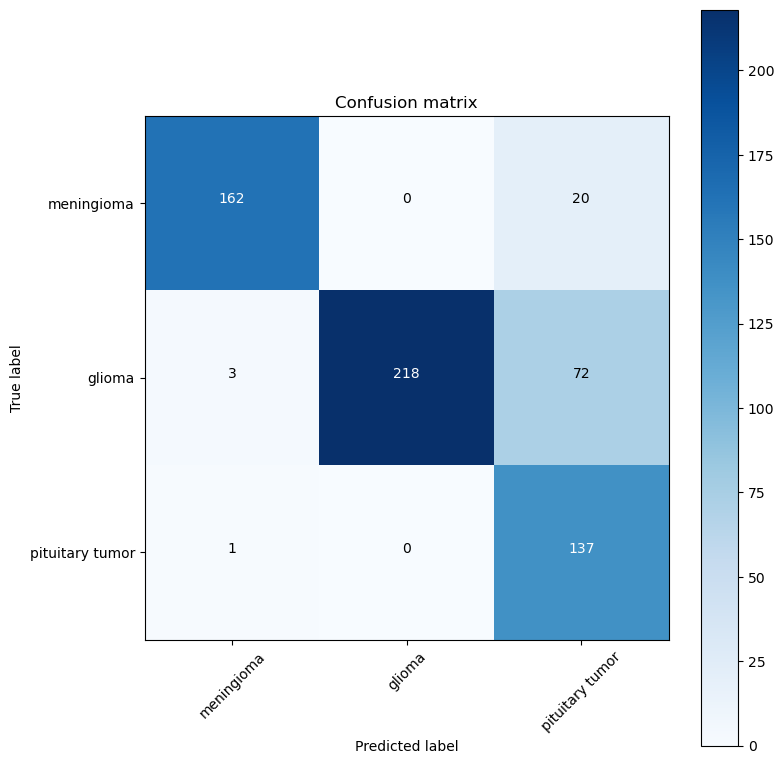

In [42]:
cnf_matrix = confusion_matrix(actual_label, predicted_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=[ 'meningioma','glioma','pituitary tumor'],
                      title='Confusion matrix')
plt.show()

**References:**
<br>
Some parts of this code and applied methods are taken from our previous project work  at ENEL645.
<br>
Also, have taken some references from other Kaggle public notebooks.
<br>
**THANK YOU**